In [1]:
# %%
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from spore_tree_config import SporeTreeConfig
from spore_tree import SporeTree
from pendulum import PendulumSystem
from visualize_spore_tree import visualize_spore_tree

In [4]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

# Создание с дефолтными параметрами
config = SporeTreeConfig()
print("Дефолтная позиция:", config.initial_position)
print("Дефолтный вектор dt:", config.get_default_dt_vector())

# Создание с кастомными параметрами  
config_custom = SporeTreeConfig(
    initial_position=np.array([0.5, 0.1]),
    dt_base=0.002,
    figure_size=(10, 10),
    dt_grandchildren_factor=0.1  # 1/10
)
config_custom.validate()

Дефолтная позиция: [3.14159265 0.        ]
Дефолтный вектор dt: [1.e-03 1.e-03 1.e-03 1.e-03 5.e-05 5.e-05 5.e-05 5.e-05 5.e-05 5.e-05
 5.e-05 5.e-05]


True

🔍 Проверяем что новый код загружен...
👶 Создано 4 детей:
  0: forw_max с dt=0.1000, цвет=#FF6B6B
  1: back_max с dt=-0.1000, цвет=#9B59B6
  2: forw_min с dt=0.1000, цвет=#1ABC9C
  3: back_min с dt=-0.1000, цвет=#F39C12

🎨 Цвета детей:
  0: forw_max → цвет: #FF6B6B
  1: back_max → цвет: #9B59B6
  2: forw_min → цвет: #1ABC9C
  3: back_min → цвет: #F39C12

📊 Проверим что цвета разные:
Уникальные цвета: {'#F39C12', '#1ABC9C', '#9B59B6', '#FF6B6B'}
Всего цветов: 4

🎨 Новая визуализация:


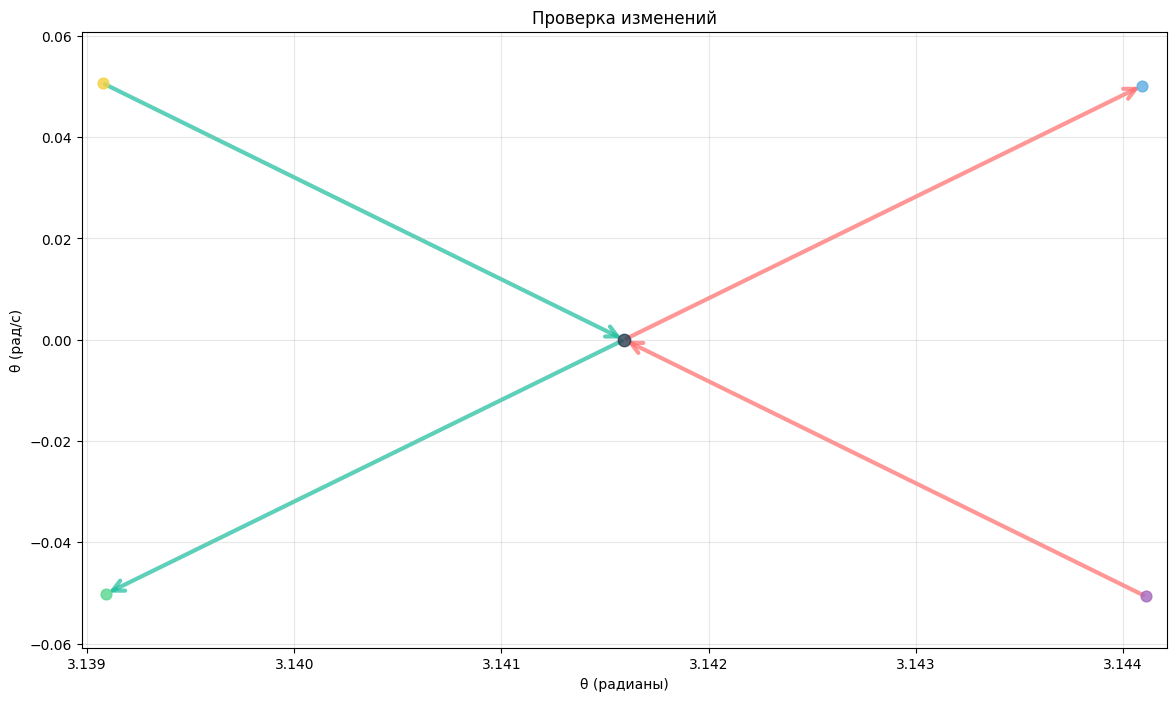

In [5]:
# Быстрый тест чтобы убедиться что изменения применились

print("🔍 Проверяем что новый код загружен...")

# Простой тест с большим dt 
config_test = SporeTreeConfig(dt_base=0.1, show_debug=False)
tree_test = SporeTree(pendulum, config_test)

# Создаем только детей для начала
children = tree_test.create_children(show=True)

print(f"\n🎨 Цвета детей:")
for i, child in enumerate(children):
    print(f"  {i}: {child['name']} → цвет: {child['color']}")

print(f"\n📊 Проверим что цвета разные:")
colors = [child['color'] for child in children]
print(f"Уникальные цвета: {set(colors)}")
print(f"Всего цветов: {len(set(colors))}")

# Визуализируем
print(f"\n🎨 Новая визуализация:")
visualize_spore_tree(tree_test, "Проверка изменений")

🔥 Экстремальный тест:
  dt_base: 0.2
  dt_grandchildren_factor: 0.5
👶 Создано 4 детей:
  0: forw_max с dt=0.2000, цвет=#FF6B6B
  1: back_max с dt=-0.2000, цвет=#9B59B6
  2: forw_min с dt=0.2000, цвет=#1ABC9C
  3: back_min с dt=-0.2000, цвет=#F39C12
👶 Создание внуков с ОБРАТНЫМ управлением:

  От родителя 0 (forw_max, u=+2.0):
    └─ Внуки будут использовать u=-2.0 (обратное)
    🌱 Внук 0: u=-2.0, dt=+0.100000 (forward) → [3.15969553 0.05856966]
    🌱 Внук 1: u=-2.0, dt=-0.100000 (backward) → [3.13905728 0.15148383]

  От родителя 1 (back_max, u=+2.0):
    └─ Внуки будут использовать u=-2.0 (обратное)
    🌱 Внук 0: u=-2.0, dt=+0.100000 (forward) → [ 3.13910752 -0.15097972]
    🌱 Внук 1: u=-2.0, dt=-0.100000 (backward) → [ 3.16013224 -0.06240027]

  От родителя 2 (forw_min, u=-2.0):
    └─ Внуки будут использовать u=+2.0 (обратное)
    🌱 Внук 0: u=+2.0, dt=+0.100000 (forward) → [ 3.12348977 -0.05856966]
    🌱 Внук 1: u=+2.0, dt=-0.100000 (backward) → [ 3.14412803 -0.15148383]

  От родит

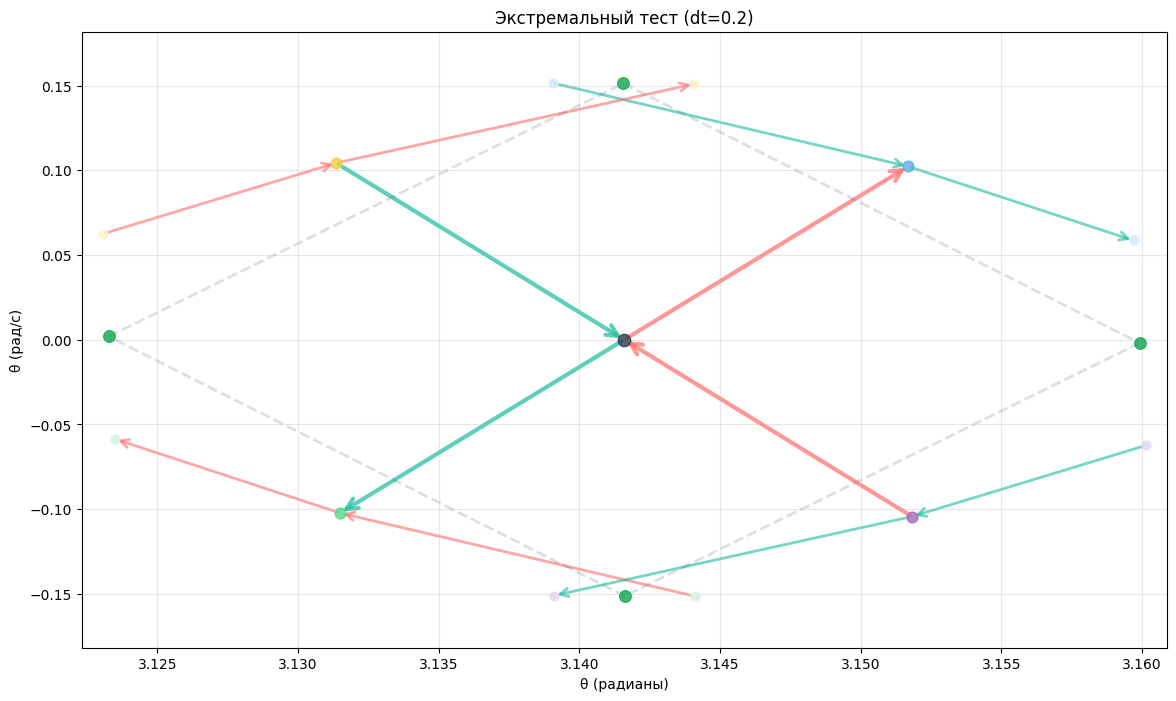

In [6]:
# Экстремальный тест для максимальной видимости различий

# Очень большой dt для наглядности
config_extreme = SporeTreeConfig(
    initial_position=np.array([np.pi, 0.0]),
    dt_base=0.2,  # Очень большой шаг!
    dt_grandchildren_factor=0.5,  # Внуки в 2 раза меньше 
    show_debug=False
)

print("🔥 Экстремальный тест:")
print(f"  dt_base: {config_extreme.dt_base}")
print(f"  dt_grandchildren_factor: {config_extreme.dt_grandchildren_factor}")

# Создаем дерево
tree_extreme = SporeTree(pendulum, config_extreme)

# Создаем всю структуру
children = tree_extreme.create_children(show=True)
grandchildren = tree_extreme.create_grandchildren(show=True)
tree_extreme.sort_and_pair_grandchildren()
tree_extreme.calculate_mean_points()

print(f"\n📏 Расстояния детей от корня:")
for i, child in enumerate(children):
    distance = np.linalg.norm(child['position'] - tree_extreme.root['position'])
    print(f"  {i}: {child['name']} → {distance:.3f}")

print(f"\n📏 Расстояния внуков от родителей:")
for gc in grandchildren:
    parent = tree_extreme.children[gc['parent_idx']]
    distance = np.linalg.norm(gc['position'] - parent['position'])
    print(f"  {gc['global_idx']}: {gc['name']} → {distance:.4f}")

print(f"\n🎨 Визуализация:")
visualize_spore_tree(tree_extreme, "Экстремальный тест (dt=0.2)")

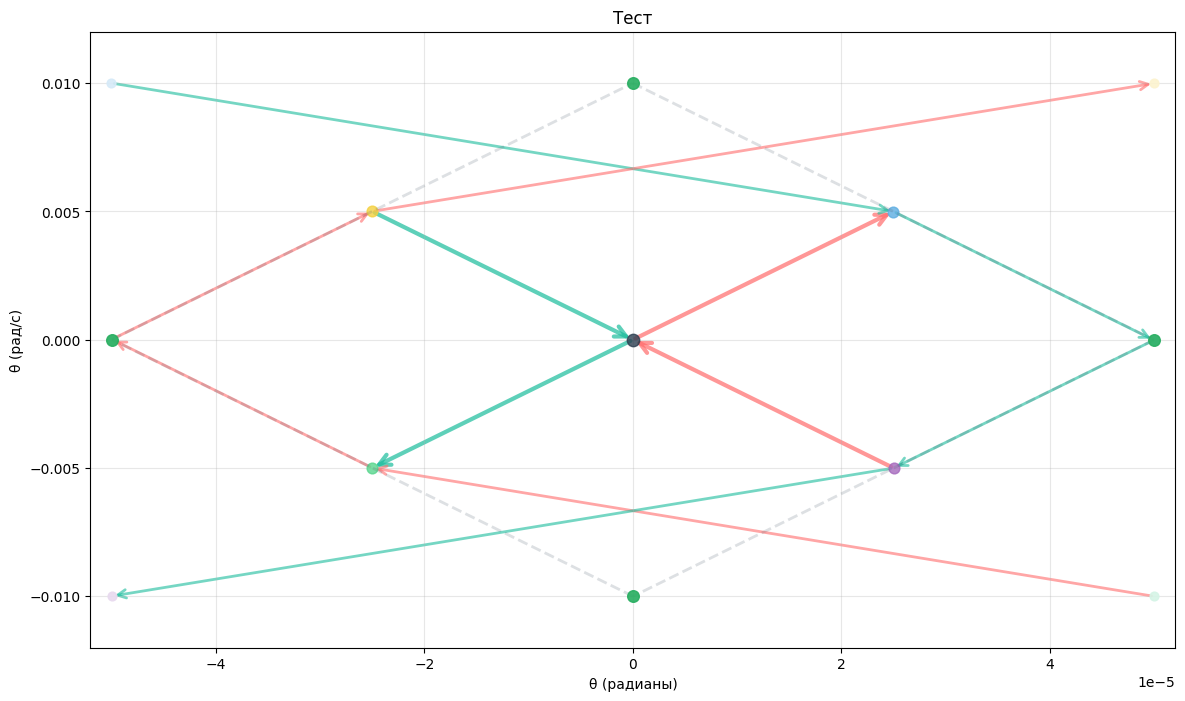

In [15]:
config_extreme = SporeTreeConfig(
    initial_position=np.array([0, 0.0]),
    dt_base=0.01,  # Очень большой шаг!
    dt_grandchildren_factor=1,  # Внуки в 2 раза меньше 
    show_debug=False
)


# Создаем дерево
tree_extreme = SporeTree(pendulum, config_extreme)

# Создаем всю структуру
children = tree_extreme.create_children(show=False)
grandchildren = tree_extreme.create_grandchildren(show=False)
tree_extreme.sort_and_pair_grandchildren()
tree_extreme.calculate_mean_points()


visualize_spore_tree(tree_extreme, "Тест")

👶 Создано 4 детей:
  0: forw_max с dt=0.1000, цвет=#FF6B6B
  1: back_max с dt=-0.1000, цвет=#9B59B6
  2: forw_min с dt=0.1000, цвет=#1ABC9C
  3: back_min с dt=-0.1000, цвет=#F39C12

✅ Проверка класса SporeTree:
Количество детей: 4
Цвета детей: ['#FF6B6B', '#9B59B6', '#1ABC9C', '#F39C12']
Имена детей: ['forw_max', 'back_max', 'forw_min', 'back_min']

✅ Тест функции визуализации:
Если видите принт 'Новая версия загружена' - функция обновилась
Если НЕ видите принт - функция старая


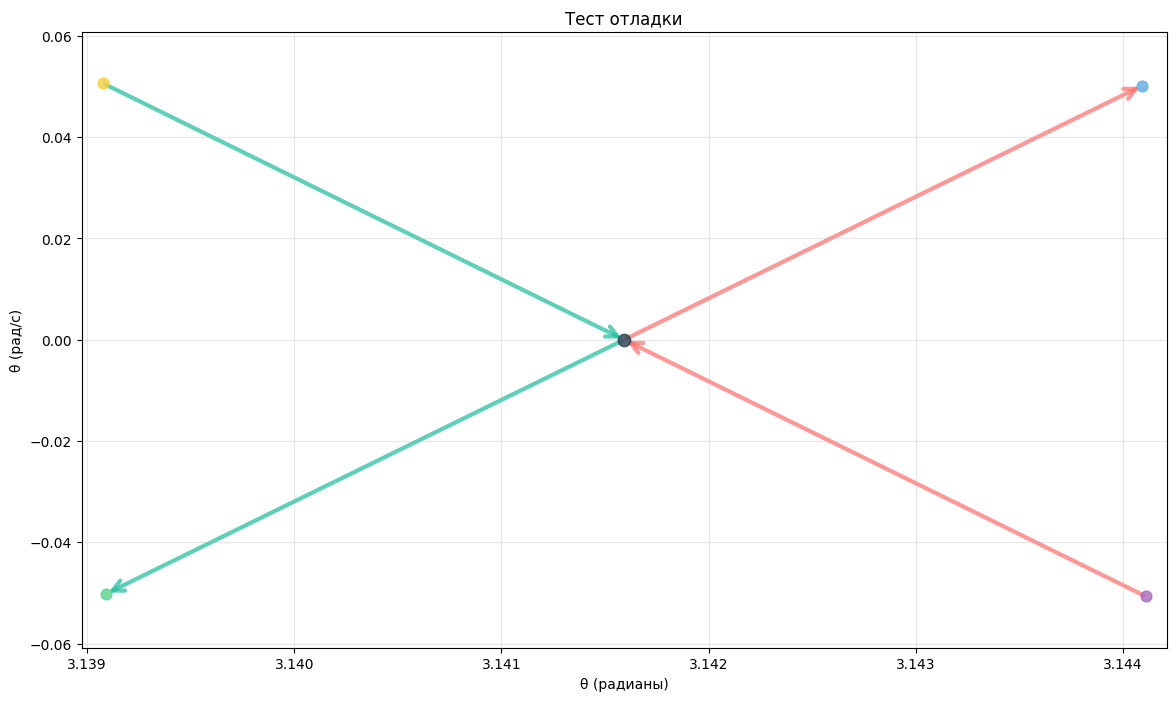


📋 Что должно быть в новой версии:
1. Принт '🎨 Новая версия visualize_spore_tree загружена!'
2. БЕЗ аннотаций на ребрах (старая версия их показывает)
3. Легенда СПРАВА от графика
4. Пунктирные стрелки для backward (dt < 0)


In [8]:
# Отладочный тест для проверки что работает

config_debug = SporeTreeConfig(dt_base=0.1, show_debug=False)
tree_debug = SporeTree(pendulum, config_debug)

# Создаем только детей
children = tree_debug.create_children(show=True)

print(f"\n✅ Проверка класса SporeTree:")
print(f"Количество детей: {len(children)}")
print(f"Цвета детей: {[child['color'] for child in children]}")
print(f"Имена детей: {[child['name'] for child in children]}")

print(f"\n✅ Тест функции визуализации:")
print("Если видите принт 'Новая версия загружена' - функция обновилась")
print("Если НЕ видите принт - функция старая")

try:
    # Этот вызов покажет загрузилась ли новая функция
    visualize_spore_tree(tree_debug, "Тест отладки")
except Exception as e:
    print(f"❌ Ошибка визуализации: {e}")

print(f"\n📋 Что должно быть в новой версии:")
print(f"1. Принт '🎨 Новая версия visualize_spore_tree загружена!'")
print(f"2. БЕЗ аннотаций на ребрах (старая версия их показывает)")
print(f"3. Легенда СПРАВА от графика")
print(f"4. Пунктирные стрелки для backward (dt < 0)")

In [9]:
# Создание и тестирование сортировки
config = SporeTreeConfig(dt_base=0.1, show_debug=True)
tree = SporeTree(pendulum, config)
tree.create_children(show=True)
tree.create_grandchildren(show=True)

# ТЕСТ нового метода
tree.sort_and_pair_grandchildren(show=True)

print(f"\n📊 Результат сортировки:")
print(f"Количество отсортированных внуков: {len(tree.sorted_grandchildren)}")

🌱 SporeTree создан с позицией [3.14159265 0.        ]
👶 Создано 4 детей:
  0: forw_max с dt=0.1000, цвет=#FF6B6B
  1: back_max с dt=-0.1000, цвет=#9B59B6
  2: forw_min с dt=0.1000, цвет=#1ABC9C
  3: back_min с dt=-0.1000, цвет=#F39C12
👶 Создание внуков с ОБРАТНЫМ управлением:

  От родителя 0 (forw_max, u=+2.0):
    └─ Внуки будут использовать u=-2.0 (обратное)
    🌱 Внук 0: u=-2.0, dt=+0.005000 (forward) → [3.14433918 0.04769846]
    🌱 Внук 1: u=-2.0, dt=-0.005000 (backward) → [3.14383758 0.052626  ]

  От родителя 1 (back_max, u=+2.0):
    └─ Внуки будут использовать u=-2.0 (обратное)
    🌱 Внук 0: u=-2.0, dt=+0.005000 (forward) → [ 3.14385193 -0.0530781 ]
    🌱 Внук 1: u=-2.0, dt=-0.005000 (backward) → [ 3.14435857 -0.0482522 ]

  От родителя 2 (forw_min, u=-2.0):
    └─ Внуки будут использовать u=+2.0 (обратное)
    🌱 Внук 0: u=+2.0, dt=+0.005000 (forward) → [ 3.13884613 -0.04769846]
    🌱 Внук 1: u=+2.0, dt=-0.005000 (backward) → [ 3.13934773 -0.052626  ]

  От родителя 3 (back_mi

In [10]:
tree.calculate_mean_points()

📊 Вычисление средних точек для 8 отсортированных внуков...
  📏 Пара 0 (внуки 0-1):
     gc_3_0_forward (родитель 3) → [3.13933337 0.0530781 ]
     gc_0_1_backward (родитель 0) → [3.14383758 0.052626  ]
     Расстояние: 0.004527, Средняя точка: [3.14158548 0.05285205]
  📏 Пара 1 (внуки 2-3):
     gc_0_0_forward (родитель 0) → [3.14433918 0.04769846]
     gc_1_1_backward (родитель 1) → [ 3.14435857 -0.0482522 ]
     Расстояние: 0.095951, Средняя точка: [ 3.14434887e+00 -2.76868531e-04]
  📏 Пара 2 (внуки 4-5):
     gc_1_0_forward (родитель 1) → [ 3.14385193 -0.0530781 ]
     gc_2_1_backward (родитель 2) → [ 3.13934773 -0.052626  ]
     Расстояние: 0.004527, Средняя точка: [ 3.14159983 -0.05285205]
  📏 Пара 3 (внуки 6-7):
     gc_2_0_forward (родитель 2) → [ 3.13884613 -0.04769846]
     gc_3_1_backward (родитель 3) → [3.13882674 0.0482522 ]
     Расстояние: 0.095951, Средняя точка: [3.13883643e+00 2.76868531e-04]

✅ Средние точки вычислены и сохранены в tree.mean_points
   🎯 Размерность: (

array([[ 3.14158548e+00,  5.28520500e-02],
       [ 3.14434887e+00, -2.76868531e-04],
       [ 3.14159983e+00, -5.28520500e-02],
       [ 3.13883643e+00,  2.76868531e-04]])

In [11]:
def visualize_mean_points(tree, title="Проверка пар внуков"):
    """
    Простая визуализация: только точки спор + линии между средними точками пар.
    
    Args:
        tree: объект SporeTree с отсортированными внуками
        title: заголовок графика
        
    Raises:
        RuntimeError: если средние точки не вычислены
    """
    if not hasattr(tree, 'mean_points'):
        raise RuntimeError("Сначала нужно вычислить средние точки через calculate_mean_points()")
    
    fig, ax = plt.subplots(1, 1, figsize=tree.config.figure_size)
    
    # === ТОЛЬКО ТОЧКИ СПОР ===
    
    # Корень - темно-серый
    ax.scatter(tree.root['position'][0], tree.root['position'][1], 
              c='#34495E', s=70, alpha=0.8, zorder=5)
    
    # Дети - приглушенные цвета
    if tree._children_created:
        child_colors = ['#5DADE2', '#A569BD', '#58D68D', '#F4D03F']  # мягкие голубой, сиреневый, зеленый, желтый
        for i, child in enumerate(tree.children):
            ax.scatter(child['position'][0], child['position'][1],
                      c=child_colors[i], s=50, alpha=0.7, zorder=4)
    
    # Внуки - очень светлые
    if tree._grandchildren_sorted:
        grandchild_colors = ['#D6EAF8', '#E8DAEF', '#D5F4E6', '#FCF3CF']  # очень светлые версии
        
        for i, gc in enumerate(tree.sorted_grandchildren):
            gc_color = grandchild_colors[gc['parent_idx']]
            ax.scatter(gc['position'][0], gc['position'][1],
                      c=gc_color, s=30, alpha=0.6, zorder=3)
    
    # === СРЕДНИЕ ТОЧКИ И ЛИНИИ ===
    
    mean_points = tree.mean_points
    
    # Средние точки - спокойный зеленый
    ax.scatter(mean_points[:, 0], mean_points[:, 1], 
              c='#239B56', s=60, alpha=0.9, zorder=10)
    
    # Линии четырехугольника - нейтральный серый
    for i in range(4):
        start_point = mean_points[i]
        end_point = mean_points[(i + 1) % 4]
        
        ax.plot([start_point[0], end_point[0]], 
                [start_point[1], end_point[1]], 
                color='#566573', linewidth=1.5, alpha=0.7, zorder=8)
    
    # === НАСТРОЙКИ ГРАФИКА ===
    
    ax.set_xlabel('θ (радианы)')
    ax.set_ylabel('θ̇ (рад/с)')
    ax.set_title(title)
    ax.grid(True, alpha=0.2)
    
    # Автоматическое масштабирование
    all_x = [tree.root['position'][0]]
    all_y = [tree.root['position'][1]]
    
    if tree._children_created:
        all_x.extend([child['position'][0] for child in tree.children])
        all_y.extend([child['position'][1] for child in tree.children])
    
    if tree._grandchildren_sorted:
        all_x.extend([gc['position'][0] for gc in tree.sorted_grandchildren])
        all_y.extend([gc['position'][1] for gc in tree.sorted_grandchildren])
        
        all_x.extend(mean_points[:, 0])
        all_y.extend(mean_points[:, 1])
    
    # Небольшие отступы
    x_range = max(all_x) - min(all_x)
    y_range = max(all_y) - min(all_y)
    x_margin = max(x_range * 0.1, 0.05)
    y_margin = max(y_range * 0.1, 0.05)
    
    ax.set_xlim(min(all_x) - x_margin, max(all_x) + x_margin)
    ax.set_ylim(min(all_y) - y_margin, max(all_y) + y_margin)
    
    plt.show()

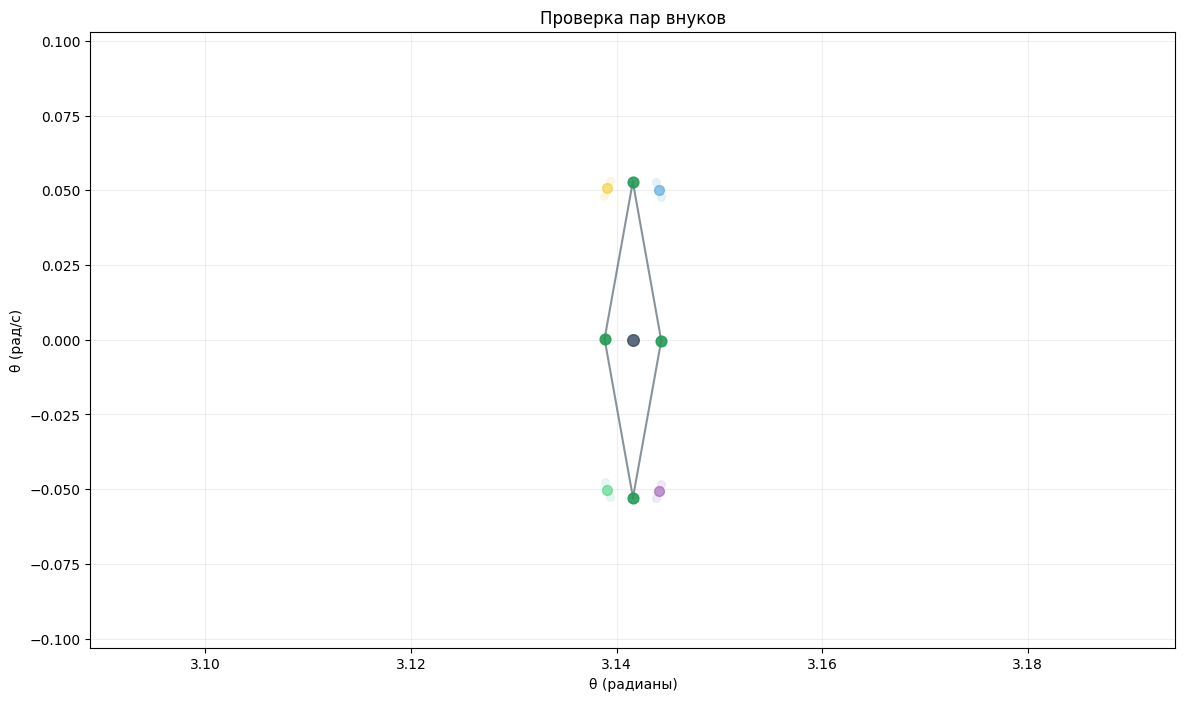

In [12]:
visualize_mean_points(tree)